Install necessary packages

In [1]:
pip install -r /workspaces/uzh-digfintools-research/resources/requirementsshort.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Equity data - D&J 60 from 2019-11-01 to 2020-11-01 (source: finance yahoo)

In [2]:
import yfinance as yf
import pandas as pd
import os

tickers = [
    'MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 
    'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 
    'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'VZ', 'V', 
    'WBA', 'WMT', 'RTX', 'TSLA', 'META', 'GOOGL', 'GOOG', 'NFLX', 'AMZN', 'BMY', 'PEP', 
    'ORCL', 'QCOM', 'TXN', 'ADP', 'COST', 'GE', 'MO', 'ABT', 'T', 
    'SBUX', 'LLY', 'BRK-B', 'PFE', 'XOM', 'MDT', 'TGT', 'SPGI', 
    'BK', 'C', 'SLB', 'DHR', 'DUK'
]
start_date = '2019-11-01'
end_date = '2020-11-01'

data = yf.download(tickers, start=start_date, end=end_date, interval='1d')['Close']
#file_path = os.path.join('/workspaces/uzh-digfintools-research/data/raw','DJ60_securities.csv')
#data.to_csv(file_path)


[*********************100%***********************]  60 of 60 completed


Risk-free data - T-bill 10Y yield for the same time period (source: finance yahoo)

In [3]:
import yfinance as yf
import pandas as pd
import os

ticker = "^TNX"

y10_data = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
y10_data.head()


rf_rate = y10_data/100
#file_path1 = os.path.join('/workspaces/uzh-digfintools-research/data/raw','10Y_Treasury_Yield.csv')
#rf_rate.to_csv(file_path1)
#print(y10_data)
descriptive_stats = rf_rate.describe()
descriptive_stats.head()

[*********************100%***********************]  1 of 1 completed


Ticker,^TNX
count,252.000000
mean,0.010363
std,0.005018
min,0.004990
25%,0.006627


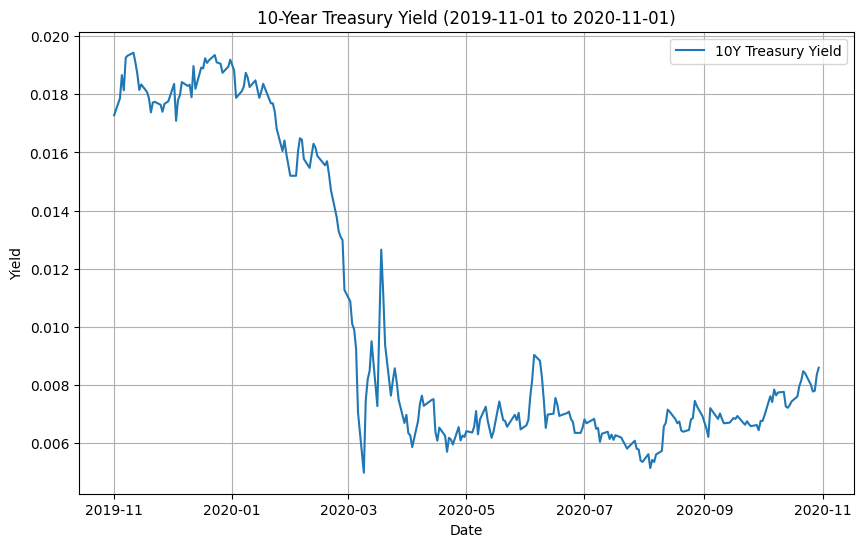

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(rf_rate, label='10Y Treasury Yield')
plt.title('10-Year Treasury Yield (2019-11-01 to 2020-11-01)')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()


Descriptive Statistics (First 4 moments):
             Mean  Variance  Skewness   Kurtosis
Ticker                                         
AAPL    0.002119  0.000835 -0.339678   4.412624
ABT     0.000957  0.000592  0.079963   4.234819
ADP    -0.000125  0.000802 -0.775537   8.204677
AMGN   -0.000019  0.000558  0.586269   3.968217
AMZN    0.002102  0.000551 -0.012720   1.545216
AXP    -0.001063  0.001393  0.404604   7.388946
BA     -0.003472  0.002904 -0.324005   6.213240
BK     -0.001262  0.000867 -0.489409   7.919173
BMY     0.000089  0.000321 -0.515083   3.668508
BRK-B  -0.000266  0.000463 -0.328247   8.250062
C      -0.002303  0.001730 -0.550753   5.796587
CAT     0.000332  0.000755 -0.813714   5.031456
COST    0.000752  0.000313  0.966322   7.168573
CSCO   -0.001076  0.000701 -0.366127   6.532870
CVX    -0.002048  0.001387 -1.117807  14.373045
DHR     0.002069  0.000430 -0.346486   5.397643
DIS    -0.000361  0.000818 -0.087196   5.781615
DOW    -0.000557  0.001520 -1.129871   9.674

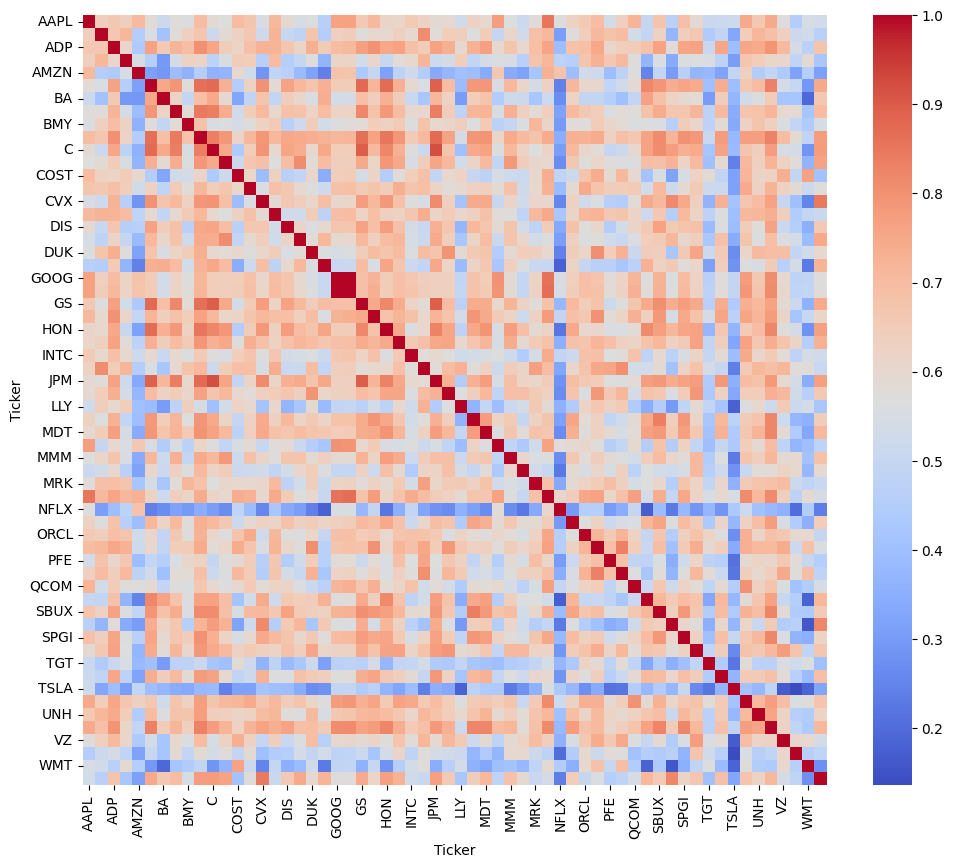

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute daily returns
daily_returns = data.pct_change().dropna()[:20]

# Compute log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Compound returns
compound_returns = (1 + daily_returns).prod() - 1

# Descriptive statistics (First 4 moments)
mean_returns = log_returns.mean()
variance = log_returns.var()
skewness = log_returns.skew()
kurtosis = log_returns.kurtosis()

# Combine the descriptive statistics into a DataFrame
descriptive_stats = pd.DataFrame({
    'Mean': mean_returns,
    'Variance': variance,
    'Skewness': skewness,
    'Kurtosis': kurtosis
})

# Calculate the correlation matrix
correlation_matrix = log_returns.corr()

# Display the compound returns and descriptive statistics
#print("Compound Returns:\n", compound_returns)
print("\nDescriptive Statistics (First 4 moments):\n", descriptive_stats)


correlation_matrix = log_returns.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Display the plot
plt.show()

Markowtiz optimisation set up

In [67]:
import numpy as np

fc = 21 #forecasting period: 21 - monthly
rb = 10 #rebalancing: 10 - biweekly
n = log_returns.shape[1] #number of securities
tperiods = int((log_returns.shape[0] - fc) / rb) - 1 #number of forecasting periods 
p0 = 0.0023 #target portfolio return - approximately average dowjones index daily return in October 2019 
eqw = np.full(n, 1 / n)  # Equally weighted portfolio
tdays = 252 
results_minvar = {
    'volatility_p': [],
    'return_p': [],
    'sharpe_ratio_p': [],
    'volatility_eqw': [],
    'return_eqw': [],
    'sharpe_ratio_eqw': [],
    'volatility_diff': [],
    'return_diff': [],
    'sharpe_ratio_diff': []
}


results_maxsr = {
    'volatility_p': [],
    'return_p': [],
    'sharpe_ratio_p': [],
    'volatility_eqw': [],
    'return_eqw': [],
    'sharpe_ratio_eqw': [],
    'volatility_diff': [],
    'return_diff': [],
    'sharpe_ratio_diff': []
}

riskfree_rate = rf_rate.values

Minimum variance optimisation

In [68]:
import cvxopt
import numpy as np


for i in range(tperiods):
# Extract the rolling window
    window = log_returns.iloc[i * rb: fc + i * rb, :]
    window_cov = window.cov()
    log_returns_target = np.mean(window, axis=0)
    

#Initiliase markowitz min var
    P = 2 * cvxopt.matrix(window_cov.values) #matrix to minimise
    q = cvxopt.matrix(np.zeros(n))
    G = cvxopt.matrix(np.vstack([-np.eye(n), log_returns_target])) #no short selling and min portfolio return
    h = cvxopt.matrix(np.append(np.zeros(n), -p0))
    A = cvxopt.matrix(np.ones([1, n])) #weights sum up to 1
    b = cvxopt.matrix([1.0])
    
#Run optimisation problem
    sol = cvxopt.solvers.qp(P,q, G, h, A, b)

    if sol['status'] != 'optimal':
        print(f"Optimization failed at iteration {i}")
        continue

    weights = np.array(sol['x']).flatten()

    #Back-testing

    return_bt = log_returns.iloc[fc + (i + 1) * rb, :].values
    variance_bt = log_returns.iloc[i * rb: fc + (i + 1) * rb, :].cov() #next period covariance

    # Portfolio variance, return and sharpe ratio
    variance_p = weights.T @ variance_bt @ weights #potrfolio variance
    volatility_p = np.sqrt(variance_p)
    return_p = weights.T @ return_bt #portfolio return daily
    sr_p = (return_p - riskfree_rate[i])/volatility_p

    #Equally weighted portfolio
    volatility_bench = np.sqrt(eqw.T @ variance_bt @ eqw)
    return_bench = eqw.T@return_bt #benchmark daily returns
    sr_bench = (return_bench - riskfree_rate[i])/volatility_bench

    #differences in performance
    volatility_diff = volatility_p-volatility_bench
    return_diff = return_p - return_bench
    sr_diff = sr_p - sr_bench

    # Append annualised results
    results_minvar['volatility_p'].append(volatility_p)
    results_minvar['return_p'].append(return_p)
    results_minvar['sharpe_ratio_p'].append(sr_p)
    results_minvar['volatility_eqw'].append(volatility_bench)
    results_minvar['return_eqw'].append(return_bench)
    results_minvar['sharpe_ratio_eqw'].append(sr_bench)
    results_minvar['volatility_diff'].append(volatility_diff)
    results_minvar['return_diff'].append(return_diff)
    results_minvar['sharpe_ratio_diff'].append(sr_diff)




     pcost       dcost       gap    pres   dres
 0:  1.7151e-05 -9.9712e-01  6e+01  8e+00  8e+00
 1:  1.7215e-05 -9.6510e-01  2e+00  1e-01  1e-01
 2:  1.7230e-05 -3.9646e-01  5e-01  2e-02  2e-02
 3:  2.0112e-05 -2.0898e-01  5e-01  2e-02  2e-02
 4:  3.9338e-05 -3.4886e-01  5e-01  2e-02  2e-02
 5:  6.7600e-05 -9.4956e-02  1e-01  4e-03  4e-03
 6:  8.5391e-05 -5.8075e-03  6e-03  4e-16  5e-16
 7:  8.4576e-05 -2.3125e-04  3e-04  2e-16  4e-17
 8:  5.0510e-05 -1.3617e-04  2e-04  4e-16  2e-18
 9:  4.0971e-05 -4.9876e-06  5e-05  2e-16  3e-18
10:  3.4979e-05  2.3794e-05  1e-05  4e-16  8e-19
11:  2.8678e-05  2.3068e-05  6e-06  2e-16  1e-18
12:  2.7081e-05  2.6382e-05  7e-07  5e-17  2e-18
13:  2.6798e-05  2.6678e-05  1e-07  2e-16  5e-18
14:  2.6720e-05  2.6718e-05  2e-09  4e-17  5e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.2902e-05 -9.9654e-01  6e+01  8e+00  8e+00
 1:  2.2964e-05 -9.6455e-01  2e+00  1e-01  1e-01
 2:  2.2976e-05 -4.3079e-01  5e-01  3e-02  3e-0

Maximum Sharpe Ratio

In [69]:
import cvxopt
import numpy as np

for i in range(tperiods):
    # Extract the rolling window
    window = log_returns.iloc[i * rb: fc + i * rb, :]
    window_cov = window.cov()
    log_returns_target = np.mean(window, axis=0)
    
    # Calculate the excess returns (over the risk-free rate)
    excess_returns = log_returns_target - riskfree_rate[i]
    
    # Initialize quadratic programming problem to maximize Sharpe ratio
    P = cvxopt.matrix(window_cov.values)  # Covariance matrix (for variance minimization)
    q = cvxopt.matrix(-excess_returns)    # Negative of the excess returns (we want to maximize returns)
    
    # Constraints: no short selling (weights >= 0) and portfolio return constraint
    G = cvxopt.matrix(-np.eye(n))         # No short selling, weights must be >= 0
    h = cvxopt.matrix(np.zeros(n))        # No short selling constraint
    
    # Fully invested portfolio: sum of weights = 1
    A = cvxopt.matrix(np.ones([1, n]))    # Weights sum up to 1
    b = cvxopt.matrix([1.0])              # Sum of weights equals 1
    
    # Run optimization problem
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    if sol['status'] != 'optimal':
        print(f"Optimization failed at iteration {i}")
        continue
    
    weights = np.array(sol['x']).flatten()  # Optimal weights

    # Back-testing
    return_bt = log_returns.iloc[fc + (i + 1) * rb, :].values  # Next period return
    variance_bt = log_returns.iloc[i * rb: fc + (i + 1) * rb, :].cov()  # Next period covariance

    # Portfolio variance, return and Sharpe ratio
    variance_p = weights.T @ variance_bt @ weights  # Portfolio variance
    volatility_p = np.sqrt(variance_p)
    return_p = weights.T @ return_bt  # Portfolio return
    sr_p = (return_p - riskfree_rate[i]) / volatility_p  # Portfolio Sharpe ratio

    # Equally weighted portfolio
    volatility_bench = np.sqrt(eqw.T @ variance_bt @ eqw)
    return_bench = eqw.T @ return_bt
    sr_bench = (return_bench - riskfree_rate[i]) / volatility_bench

    # Differences in performance
    volatility_diff = volatility_p - volatility_bench
    return_diff = return_p - return_bench
    sr_diff = sr_p - sr_bench

    # Append results
    results_maxsr['volatility_p'].append(volatility_p)
    results_maxsr['return_p'].append(return_p)
    results_maxsr['sharpe_ratio_p'].append(sr_p)
    results_maxsr['volatility_eqw'].append(volatility_bench)
    results_maxsr['return_eqw'].append(return_bench)
    results_maxsr['sharpe_ratio_eqw'].append(sr_bench)
    results_maxsr['volatility_diff'].append(volatility_diff)
    results_maxsr['return_diff'].append(return_diff)
    results_maxsr['sharpe_ratio_diff'].append(sr_diff)

     pcost       dcost       gap    pres   dres
 0:  1.6468e-02 -9.8940e-01  1e+00  4e-16  8e+00
 1:  1.6460e-02  6.0244e-04  2e-02  1e-16  1e-01
 2:  1.6015e-02  1.0525e-02  5e-03  1e-16  4e-02
 3:  1.4159e-02  8.7384e-03  5e-03  1e-16  3e-02
 4:  1.1541e-02  1.1049e-02  5e-04  1e-16  3e-04
 5:  1.1081e-02  1.1076e-02  5e-06  1e-16  2e-06
 6:  1.1076e-02  1.1076e-02  5e-08  2e-16  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6446e-02 -9.8814e-01  1e+00  4e-16  8e+00
 1:  1.6437e-02  1.8583e-03  1e-02  2e-16  1e-01
 2:  1.6004e-02  1.1777e-02  4e-03  3e-17  3e-02
 3:  1.4817e-02  1.0625e-02  4e-03  2e-16  3e-02
 4:  1.2701e-02  1.2239e-02  5e-04  1e-16  5e-17
 5:  1.2336e-02  1.2328e-02  8e-06  3e-16  6e-17
 6:  1.2329e-02  1.2329e-02  8e-08  1e-16  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6220e-02 -9.9324e-01  1e+00  7e-16  8e+00
 1:  1.6209e-02 -3.2410e-03  2e-02  1e-16  2e-01
 2:  1.5663e-02  6.6737e

Plots

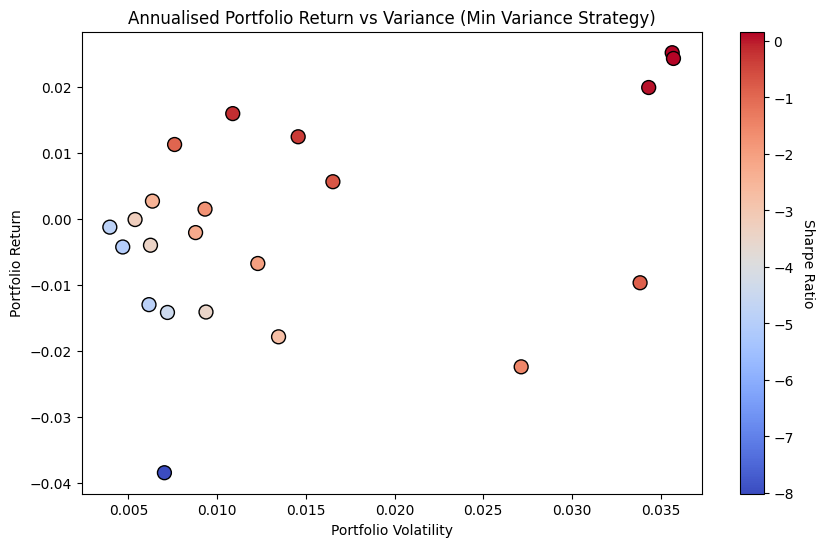

In [62]:
# Scatter plot for Minimum Variance Strategy
plt.figure(figsize=(10, 6))

# Extracting data for the minimum variance strategy
returns_minvar = np.array(results_minvar['return_p'])  # Portfolio returns
volatility_minvar = np.array(results_minvar['volatility_p'])  # Portfolio volatility
sharpe_ratios_minvar = np.array(results_minvar['sharpe_ratio_p'])  # Sharpe ratios

# Scatter plot with Sharpe ratio as color
sc_minvar = plt.scatter(volatility_minvar, returns_minvar, c=sharpe_ratios_minvar, cmap='coolwarm', s=100, edgecolor='k')
cbar_minvar = plt.colorbar(sc_minvar)
cbar_minvar.set_label('Sharpe Ratio', rotation=270, labelpad=15)

plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.title('Annualised Portfolio Return vs Variance (Min Variance Strategy)')
plt.show()

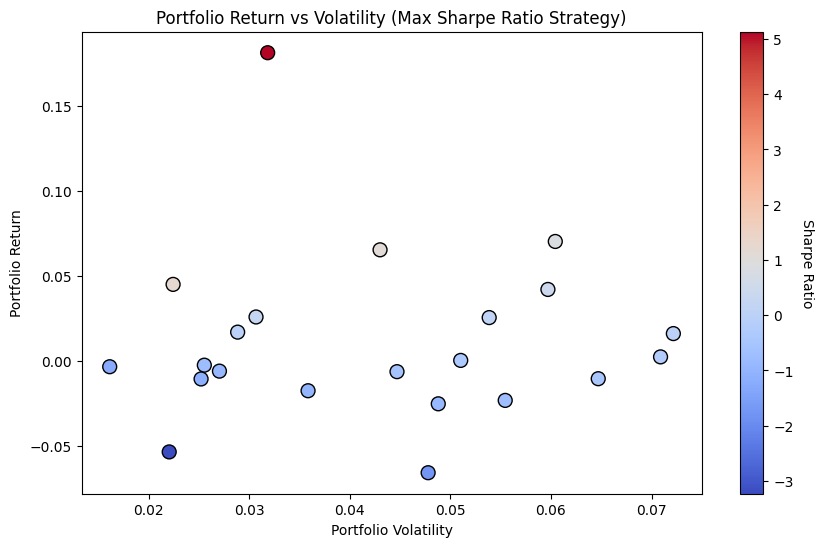

In [63]:
# Scatter plot for Maximum Sharpe Ratio Strategy (using volatility)
plt.figure(figsize=(10, 6))

# Extracting data for the maximum Sharpe ratio strategy
returns_maxsr = np.array(results_maxsr['return_p'])  # Portfolio returns
volatility_maxsr = np.array(results_maxsr['volatility_p'])  # Portfolio volatilities (already sqrt of variance)
sharpe_ratios_maxsr = np.array(results_maxsr['sharpe_ratio_p'])  # Sharpe ratios

# Scatter plot with Sharpe ratio as color
sc_maxsr = plt.scatter(volatility_maxsr, returns_maxsr, c=sharpe_ratios_maxsr, cmap='coolwarm', s=100, edgecolor='k')
cbar_maxsr = plt.colorbar(sc_maxsr)
cbar_maxsr.set_label('Sharpe Ratio', rotation=270, labelpad=15)

plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.title('Portfolio Return vs Volatility (Max Sharpe Ratio Strategy)')
plt.show()

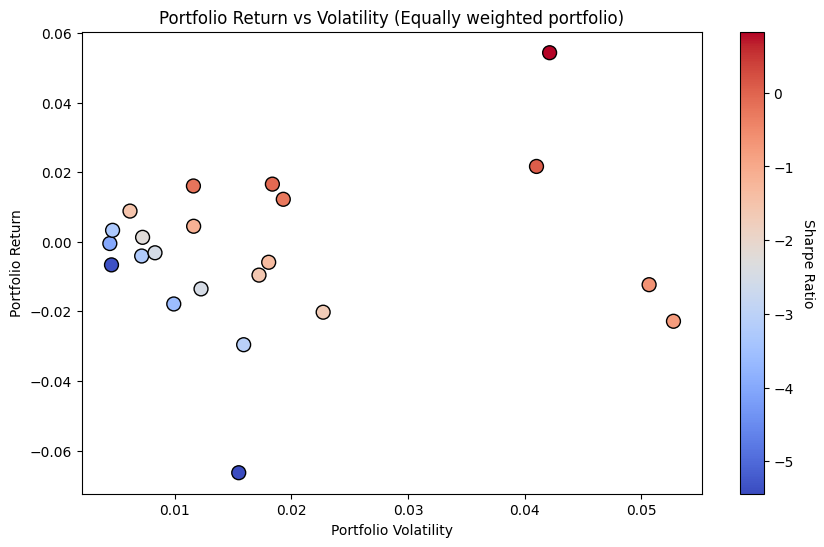

In [64]:
# Scatter plot for Maximum Sharpe Ratio Strategy (using volatility)
plt.figure(figsize=(10, 6))

# Extracting data for the maximum Sharpe ratio strategy
returns_b = np.array(results_maxsr['return_eqw'])  # Portfolio returns
volatility_b = np.array(results_maxsr['volatility_eqw'])  # Portfolio volatilities (already sqrt of variance)
sharpe_ratios_b = np.array(results_maxsr['sharpe_ratio_eqw'])  # Sharpe ratios

# Scatter plot with Sharpe ratio as color
sc_b = plt.scatter(volatility_b, returns_b, c=sharpe_ratios_b, cmap='coolwarm', s=100, edgecolor='k')
cbar_b = plt.colorbar(sc_b)
cbar_b.set_label('Sharpe Ratio', rotation=270, labelpad=15)

plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.title('Portfolio Return vs Volatility (Equally weighted portfolio)')
plt.show()

In [78]:
#Generate dates

import pandas as pd
# The initial start date
start_date = pd.to_datetime("2019-11-01")
end_date = pd.to_datetime("2020-11-01")

forecasted_days = fc + 2 * rb
start_f_date = start_date + pd.tseries.offsets.BDay(forecasted_days)


dates_df = pd.date_range(start=start_f_date, end=end_date, periods=tperiods)

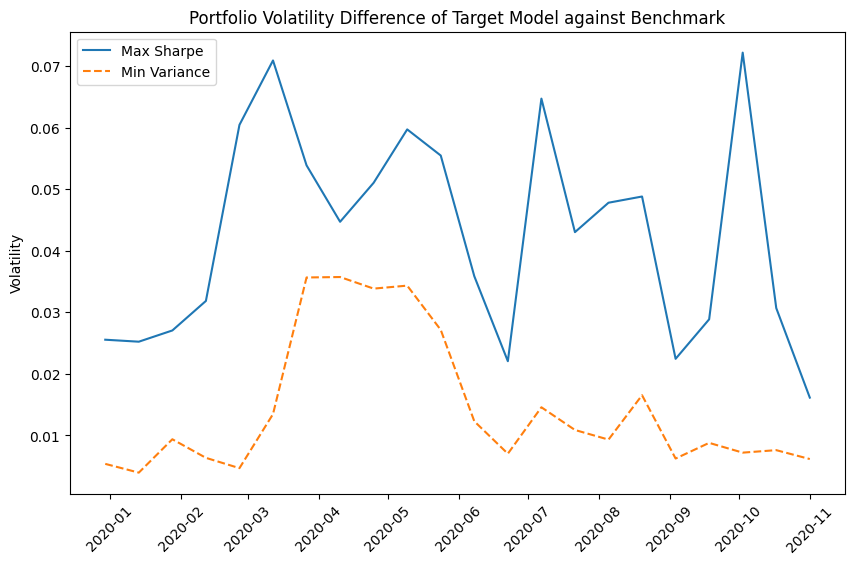

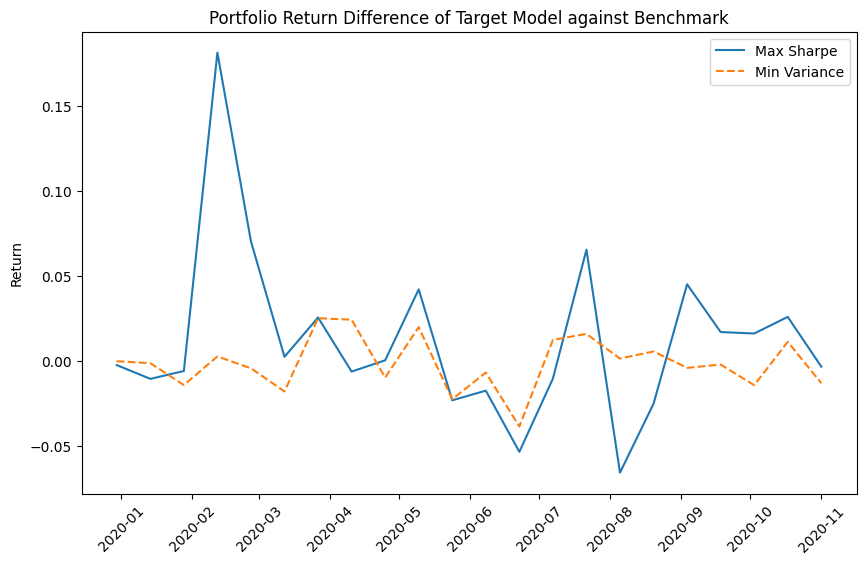

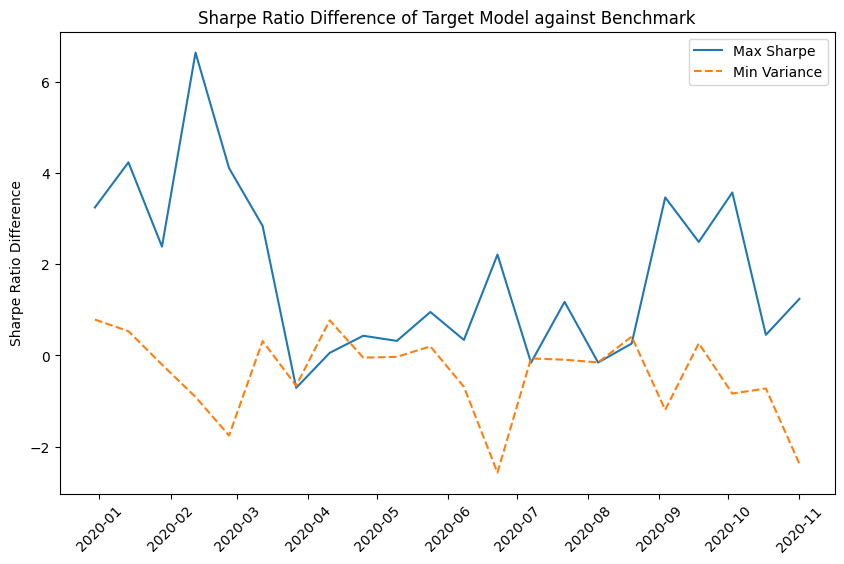

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plotting volatility for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(dates_df, results_maxsr['volatility_p'], label="Max Sharpe")
plt.plot(dates_df, results_minvar['volatility_p'], label="Min Variance", linestyle="--")
plt.ylabel("Volatility")
plt.title("Portfolio Volatility Difference of Target Model against Benchmark")
plt.xticks(rotation=45)
plt.legend()
plt.show()


# Plotting returns for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(dates_df, results_maxsr['return_p'], label="Max Sharpe")
plt.plot(dates_df, results_minvar['return_p'], label="Min Variance", linestyle="--")
plt.ylabel("Return")
plt.title("Portfolio Return Difference of Target Model against Benchmark")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plotting Sharpe ratio difference for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(dates_df, results_maxsr['sharpe_ratio_diff'], label="Max Sharpe")
plt.plot(dates_df, results_minvar['sharpe_ratio_diff'], label="Min Variance", linestyle="--")
plt.ylabel("Sharpe Ratio Difference")
plt.title("Sharpe Ratio Difference of Target Model against Benchmark")
plt.xticks(rotation=45)
plt.legend()
plt.show()